In [36]:
# %%
# ------------------------------------------------------------------------------
# Import Libraries
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from xgboost import XGBRegressor


In [26]:

# %%
# ------------------------------------------------------------------------------
# Data Loading and Initial Preparation
# ------------------------------------------------------------------------------
# Load the dataset
data = pd.read_csv("Dataset.csv")

# Define the ordinal mapping for credit ratings
rating_order = {
    'AAA': 1, 'AA+': 2, 'AA': 3, 'AA-': 4, 'A+': 5, 'A': 6, 'A-': 7,
    'BBB+': 8, 'BBB': 9, 'BBB-': 10, 'BB+': 11, 'BB': 12, 'BB-': 13,
    'B+': 14, 'B': 15, 'B-': 16, 'CCC+': 17, 'CCC': 18, 'CCC-': 19,
    'CC+': 20, 'CC': 21, 'C': 22, 'D': 23
}
data['Rating_Order'] = data['Rating'].map(rating_order)


In [27]:

# %%
# ------------------------------------------------------------------------------
# Feature Engineering and Cleaning
# ------------------------------------------------------------------------------
# Drop columns that are not useful for modeling
# Ticker, SIC Code, CIK are identifiers. Rating Agency, Date, and original Rating string are redundant.
cols_to_drop_initial = ['Rating Agency', 'Corporation', 'Ticker', 'SIC Code', 'CIK', 'Rating Date', 'Rating']
cleaned_data = data.drop(columns=cols_to_drop_initial)

# Based on correlation analysis, some features are highly redundant.
# We also drop 'Binary Rating' as we are predicting the full ordinal scale.
cols_to_drop_correlated = [
    'EBITDA Margin', 'Pre-Tax Profit Margin', 'ROI - Return On Investment',
    'Operating Margin', 'Binary Rating'
]
cleaned_data = cleaned_data.drop(columns=cols_to_drop_correlated, errors='ignore')

# One-Hot Encode the 'Sector' column
cleaned_data = pd.get_dummies(cleaned_data, columns=['Sector'], drop_first=True)


In [28]:

# %%
# ------------------------------------------------------------------------------
# Define Features (X) and Target (y) for Regression
# ------------------------------------------------------------------------------
# The target 'y' is the numerical 'Rating_Order'
# Features 'X' are all other columns
X = cleaned_data.drop(columns=['Rating_Order'])
y = cleaned_data['Rating_Order']

# Ensure all feature columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')
# Handle any potential NaNs that might arise from coercion or were already present
X.fillna(X.median(), inplace=True)


# %%
# ------------------------------------------------------------------------------
# Train-Test Split
# ------------------------------------------------------------------------------
# We stratify by the target variable to ensure both train and test sets have a similar distribution of ratings.
# Note: Stratification is typically for classification, but can be useful here if some ratings are rare.
# If it causes issues due to very rare classes, we can remove the 'stratify' argument.
# Drop very rare classes (≤2 samples)
class_counts = y.value_counts()
valid_classes = class_counts[class_counts > 2].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# %%
# ------------------------------------------------------------------------------
# Feature Scaling
# ------------------------------------------------------------------------------
# Identify numeric columns to scale
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

# Initialize the scaler and apply it
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [39]:

# # %%
# # ------------------------------------------------------------------------------
# # Model Training (XGBoost Regressor)
# # ------------------------------------------------------------------------------
# # Initialize the XGBoost Regressor model
# # We use 'reg:squarederror' as the objective for regression.
# xgb_reg = XGBRegressor(
#     objective='reg:squarederror',
#     eval_metric='rmse',  # Root Mean Squared Error
#     random_state=42
# )
# %%


# # ------------------------------------------------------------------------------
# # Hyperparameter Tuning with a Custom Scorer for Accuracy
# # ------------------------------------------------------------------------------

# # First, define a function that calculates accuracy after rounding and clipping.
# # This is the metric we actually care about.
# def rounded_accuracy_scorer(y_true, y_pred):
#     """
#     A custom scoring function that rounds, clips, and then calculates accuracy.
#     """
#     # Round the continuous predictions from the regressor
#     y_pred_rounded = np.round(y_pred)
    
#     # Clip the predictions to ensure they are within the valid rating range
#     # We get the min/max from the true labels to be safe.
#     min_rating = y_true.min()
#     max_rating = y_true.max()
#     y_pred_clipped = np.clip(y_pred_rounded, min_rating, max_rating)
    
#     # Return the final accuracy score
#     return accuracy_score(y_true, y_pred_clipped)

# # Use make_scorer to convert our function into something GridSearchCV can use.
# # We tell it 'greater_is_better=True' because we want to maximize accuracy.
# accuracy_after_rounding = make_scorer(rounded_accuracy_scorer, greater_is_better=True)


# # Define the parameter grid to search
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.05, 0.1],
#     'subsample': [0.7, 0.8],
#     'colsample_bytree': [0.7, 0.8]
# }

# # Initialize the XGBoost Regressor model
# xgb_reg = XGBRegressor(
#     objective='reg:squarederror',
#     random_state=42
# )

# # Initialize GridSearchCV, but this time using our custom scorer
# grid_search = GridSearchCV(
#     estimator=xgb_reg,
#     param_grid=param_grid,
#     scoring=accuracy_after_rounding,  # <-- The key change is here!
#     cv=3,
#     n_jobs=-1,
#     verbose=2
# )

# # Fit the grid search to the data. It will now find the params that maximize our custom score.
# print("Starting Hyperparameter Tuning (Optimizing for Accuracy)...")
# grid_search.fit(X_train, y_train)

# # Get the best model from the grid search
# best_xgb_reg = grid_search.best_estimator_
# print("\nBest Parameters Found (for maximizing accuracy):")
# print(grid_search.best_params_)


# %%
# ------------------------------------------------------------------------------
# Hyperparameter Tuning with a Custom Scorer for Accuracy
# ------------------------------------------------------------------------------

# First, define a function that calculates accuracy after rounding and clipping.
# This is the metric we actually care about.
def rounded_accuracy_scorer(y_true, y_pred):
    """
    A custom scoring function that rounds, clips, and then calculates accuracy.
    """
    # Round the continuous predictions from the regressor
    y_pred_rounded = np.round(y_pred)
    
    # Clip the predictions to ensure they are within the valid rating range
    # We get the min/max from the true labels to be safe.
    min_rating = y_true.min()
    max_rating = y_true.max()
    y_pred_clipped = np.clip(y_pred_rounded, min_rating, max_rating)
    
    # Return the final accuracy score
    return accuracy_score(y_true, y_pred_clipped)

# Use make_scorer to convert our function into something GridSearchCV can use.
# We tell it 'greater_is_better=True' because we want to maximize accuracy.
accuracy_after_rounding = make_scorer(rounded_accuracy_scorer, greater_is_better=True)


# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# Initialize the XGBoost Regressor model
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# Initialize GridSearchCV, but this time using our custom scorer
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring=accuracy_after_rounding,  # <-- The key change is here!
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the data. It will now find the params that maximize our custom score.
print("Starting Hyperparameter Tuning (Optimizing for Accuracy)...")
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xgb_reg = grid_search.best_estimator_
print("\nBest Parameters Found (for maximizing accuracy):")
print(grid_search.best_params_)

Starting Hyperparameter Tuning (Optimizing for Accuracy)...
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best Parameters Found (for maximizing accuracy):
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [44]:

# %%
# ------------------------------------------------------------------------------
# Prediction and Post-processing
# ------------------------------------------------------------------------------
# Predict continuous values on the test set
y_pred_continuous = best_xgb_reg.predict(X_test)


# Round the predictions to the nearest integer to get the rating category
y_pred_rounded = np.round(y_pred_continuous)

# Clip the predictions to ensure they are within the valid rating range [1, 23]
min_rating = int(y.min())
max_rating = int(y.max())
y_pred_final = np.clip(y_pred_rounded, min_rating, max_rating).astype(int)


In [45]:

# %%
# ------------------------------------------------------------------------------
# Model Evaluation
# ------------------------------------------------------------------------------

# 1. Regression Metrics (on the continuous predictions)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_continuous))
print(f"--- Regression Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}\n")
print("This tells us, on average, how far the continuous predictions were from the actual numerical rating.")
print("-" * 30)


--- Regression Performance ---
Root Mean Squared Error (RMSE): 1.6578

This tells us, on average, how far the continuous predictions were from the actual numerical rating.
------------------------------


In [46]:

# 2. Classification Metrics (on the final, rounded predictions)
accuracy = accuracy_score(y_test, y_pred_final)
print(f"\n--- Classification Performance (after rounding) ---")
print(f"Accuracy Score: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_final))



--- Classification Performance (after rounding) ---
Accuracy Score: 0.3639

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.33      0.48        18
           2       0.38      0.20      0.26        15
           3       0.46      0.32      0.38        37
           4       0.40      0.24      0.30        51
           5       0.34      0.41      0.37        96
           6       0.36      0.34      0.35       167
           7       0.32      0.43      0.37       144
           8       0.40      0.42      0.41       169
           9       0.41      0.41      0.41       182
          10       0.39      0.39      0.39       141
          11       0.44      0.47      0.46       109
          12       0.34      0.36      0.35        91
          13       0.17      0.16      0.17        85
          14       0.32      0.25      0.28        84
          15       0.28      0.34      0.30        62
          16       0.48      0.36  

c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aksha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aksha\anaconda3\Lib\site-packages\sklea

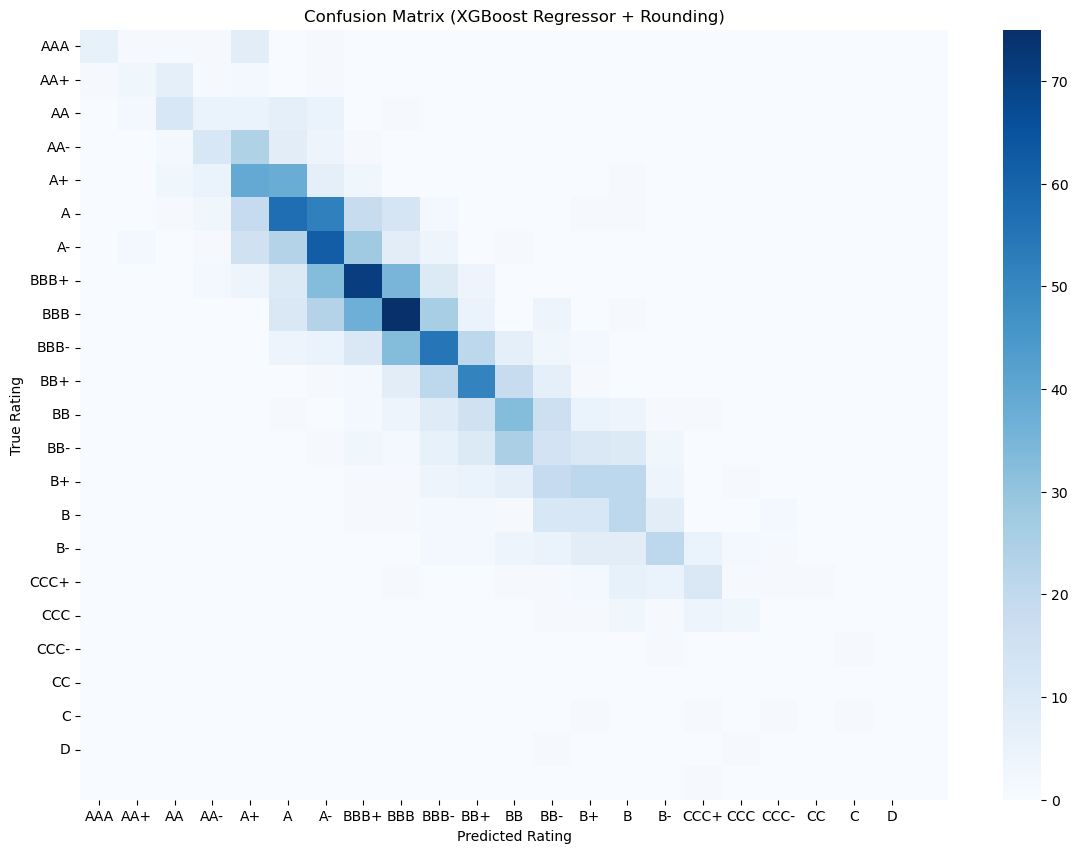

In [47]:

# %%
# ------------------------------------------------------------------------------
# Visualization: Confusion Matrix
# ------------------------------------------------------------------------------
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Create a mapping from rating order back to string for better labels
inv_rating_order = {v: k for k, v in rating_order.items()}
tick_labels = [inv_rating_order.get(i, str(i)) for i in sorted(y_test.unique())]


plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d",
            xticklabels=tick_labels, yticklabels=tick_labels)
plt.title("Confusion Matrix (XGBoost Regressor + Rounding)")
plt.xlabel("Predicted Rating")
plt.ylabel("True Rating")
plt.show()


